In [457]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

# 1.0 Prepare Data

- Data cleaning
- Prepare metric tables

In [325]:
# import datasets
df=pd.read_csv('QVI_data.csv')

# get date
df['DATE']=pd.to_datetime(df.DATE)
df['YEARMONTH']=df.DATE.dt.strftime('%Y%m').astype('int')

In [326]:
# define the measure calculations

measureOverTime=pd.DataFrame(columns=['TOT_SALES','N_CUSTOMERS','N_TXN_PER_CUST','N_CHIPS_PER_TXN','AVG_PRICE_PER_UNIT'])
measureOverTime['TOT_SALES']=df.groupby(['STORE_NBR','YEARMONTH'])['TOT_SALES'].sum() # total sales
measureOverTime['N_CUSTOMERS']=df.groupby(['STORE_NBR','YEARMONTH'])['LYLTY_CARD_NBR'].nunique() #counts of unique customers
measureOverTime['N_TXN_PER_CUST']=df.groupby(['STORE_NBR','YEARMONTH']).size()/df.groupby(['STORE_NBR','YEARMONTH'])['LYLTY_CARD_NBR'].nunique()#transaction per customer
measureOverTime['N_CHIPS_PER_TXN']=df.groupby(['STORE_NBR','YEARMONTH'])['PROD_QTY'].sum()/df.groupby(['STORE_NBR','YEARMONTH'])['LYLTY_CARD_NBR'].nunique() #Chips per customer
measureOverTime['AVG_PRICE_PER_UNIT']=df.groupby(['STORE_NBR','YEARMONTH'])['TOT_SALES'].sum()/df.groupby(['STORE_NBR','YEARMONTH'])['PROD_QTY'].sum() #average price per unit

print(measureOverTime.head(),measureOverTime.shape)

                     TOT_SALES  N_CUSTOMERS  N_TXN_PER_CUST  N_CHIPS_PER_TXN  \
STORE_NBR YEARMONTH                                                            
1         201807         206.9           49        1.061224         1.265306   
          201808         176.1           42        1.023810         1.285714   
          201809         278.8           59        1.050847         1.271186   
          201810         188.1           44        1.022727         1.318182   
          201811         192.6           46        1.021739         1.239130   

                     AVG_PRICE_PER_UNIT  
STORE_NBR YEARMONTH                      
1         201807               3.337097  
          201808               3.261111  
          201809               3.717333  
          201810               3.243103  
          201811               3.378947   (3169, 5)


In [327]:
# filter stores with full 12-month observations
measureOverTime=measureOverTime.reset_index()
store_month_obs=measureOverTime['STORE_NBR'].value_counts().to_frame()
store_nbr_fullobs=store_month_obs[store_month_obs['STORE_NBR']==12].index
measureOverTime=measureOverTime[measureOverTime['STORE_NBR'].isin(store_nbr_fullobs)]

# get the measure tables for pre trial period for further analysis
preTrialMeasures=measureOverTime[measureOverTime['YEARMONTH']<201902]

# get observations during trial period for further analysis
trialMeasure=measureOverTime[(measureOverTime['YEARMONTH']>=201902) & (measureOverTime['YEARMONTH']<=201904)]

# 2.0 Selection of Control Store

- Based on correlations
- Based on standardised magnitude of distance between measures
- Selection and summary 

### Based on correlations

In [328]:
def CalcCorrTable(metricCol,storeComparison,inputTable=preTrialMeasures,trial_store=[77,86,88]):
    #inputTable: metric table with potential comparison stores
    #metricCol: store metric used to calculate correlations
    #storeComparison: store number of the trial store
    
    ctrl_nbr=inputTable[~inputTable['STORE_NBR'].isin(trial_store)]['STORE_NBR'].unique()
    Calc_Corr_Table=pd.DataFrame(columns=['YEARMONTH','TRIAL_STORE','CTRL_STORE','CORR_SCORE'])
    trial_metric=inputTable[inputTable['STORE_NBR']==storeComparison][metricCol].reset_index()
    for ctrl in ctrl_nbr:
        ctrl_metric=inputTable[inputTable['STORE_NBR']==ctrl][metricCol].reset_index()
        Corr_Table=pd.DataFrame(columns=['YEARMONTH','TRIAL_STORE','CTRL_STORE','CORR_SCORE'])
        Corr_Table['CORR_SCORE']=ctrl_metric.corrwith(trial_metric,axis=1)
        Corr_Table['YEARMONTH']=list(inputTable[inputTable['STORE_NBR']==storeComparison]['YEARMONTH'])
        Corr_Table['TRIAL_STORE']=storeComparison
        Corr_Table['CTRL_STORE']=ctrl
        Calc_Corr_Table=pd.concat([Calc_Corr_Table,Corr_Table])
    return Calc_Corr_Table
    

In [329]:
# test the function:
CalcCorrTable(metricCol=['TOT_SALES','N_TXN_PER_CUST'],storeComparison=77,inputTable=preTrialMeasures,trial_store=[77,86,88])

,YEARMONTH,TRIAL_STORE,CTRL_STORE,CORR_SCORE
0,201807,77,1,-0.189935
1,201808,77,1,-0.236633
2,201809,77,1,-0.269937
3,201810,77,1,-0.288135
4,201811,77,1,-0.236612
...,...,...,...,...
2,201809,77,272,0.987216
3,201810,77,272,0.995351
4,201811,77,272,0.986859
5,201812,77,272,0.983738


### Based on standardised magnitude of distance between measures

In [330]:
def CalcDistTable(metricCol,storeComparison,inputTable=preTrialMeasures,trial_store=[77,86,88]):
    
    ctrl_nbr=inputTable[~inputTable['STORE_NBR'].isin(trial_store)]['STORE_NBR'].unique()
    Dis_Table=pd.DataFrame()
    trial_metric=inputTable[inputTable['STORE_NBR']==storeComparison].reset_index()[metricCol]
    for ctrl in ctrl_nbr:
        ctrl_metric=inputTable[inputTable['STORE_NBR']==ctrl].reset_index()[metricCol]
        Diff=abs(trial_metric-ctrl_metric)
        Diff['YEARMONTH']=list(inputTable[inputTable['STORE_NBR']==storeComparison]['YEARMONTH'])
        Diff['TRIAL_STORE']=storeComparison
        Diff['CTRL_STORE']=ctrl
        Dis_Table=pd.concat([Dis_Table,Diff])    
    
    # normalised the measures:
    for metrics in metricCol:
        Dis_Table[metrics]=1-(Dis_Table[metrics]-Dis_Table[metrics].min())/(Dis_Table[metrics].max()-Dis_Table[metrics].min())
        Dis_Table['MAGNITUDE_SCORE']=Dis_Table[metricCol].mean(axis=1)
    return Dis_Table

In [331]:
# test the function
CalcDistTable(metricCol=['TOT_SALES'],storeComparison=77,inputTable=preTrialMeasures,trial_store=[77,86,88])

,TOT_SALES,YEARMONTH,TRIAL_STORE,CTRL_STORE,MAGNITUDE_SCORE
0,0.935431,201807,77,1,0.935431
1,0.942972,201808,77,1,0.942972
2,0.961503,201809,77,1,0.961503
3,0.988221,201810,77,1,0.988221
4,0.962149,201811,77,1,0.962149
...,...,...,...,...,...
2,0.942900,201809,77,272,0.942900
3,0.837607,201810,77,272,0.837607
4,0.905983,201811,77,272,0.905983
5,0.901889,201812,77,272,0.901889


### Selection and summary

#### For trial store 77

In [332]:
# based on TOTAL SALES and NO OF CUSTOMERS

for measure in ['TOT_SALES','N_CUSTOMERS']:
    Corr_Table=CalcCorrTable(measure,77)
    Dis_Table=CalcDistTable([measure],77)
    Compo_Table=pd.merge(Corr_Table,Dis_Table,on=['YEARMONTH','TRIAL_STORE','CTRL_STORE'])
    Compo_Table['COMPO_SCORE']=Compo_Table['MAGNITUDE_SCORE']*0.5 + abs(Compo_Table['CORR_SCORE'])*0.5
    print(measure,'top 3 stores with scores are \n',Compo_Table.groupby(['CTRL_STORE']).agg({'COMPO_SCORE':'mean'}).sort_values(by='COMPO_SCORE',ascending=False).iloc[:3])

TOT_SALES top 3 stores with scores are 
             COMPO_SCORE
CTRL_STORE             
233            0.993238
255            0.989739
188            0.988831
N_CUSTOMERS top 3 stores with scores are 
             COMPO_SCORE
CTRL_STORE             
233            0.996566
41             0.988324
111            0.984203


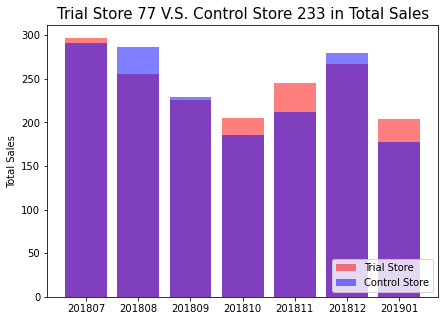

In [333]:
# Visualise the comparison of TOTAL SALES for 77 & 233

fig,ax=plt.subplots(figsize=(7,5))

x=np.arange(len(preTrialMeasures[preTrialMeasures['STORE_NBR']==77]['YEARMONTH']))

rect_trial=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==77]['TOT_SALES'],color='red',alpha=0.5,label='Trial Store')
rect_ctrl=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==233]['TOT_SALES'],color='blue',alpha=0.5,label='Control Store')

ax.set_ylabel('Total Sales',fontsize=10)
ax.set_title('Trial Store 77 V.S. Control Store 233 in Total Sales',fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(preTrialMeasures[preTrialMeasures['STORE_NBR']==77]['YEARMONTH'])
ax.legend(loc='lower right')

plt.show()

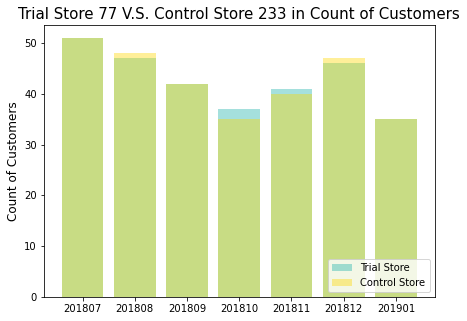

In [334]:
# Visualise the comparison of NO OF CUSTOMERS for 77 & 233

fig,ax=plt.subplots(figsize=(7,5))

x=np.arange(len(preTrialMeasures[preTrialMeasures['STORE_NBR']==77]['YEARMONTH']))

rect_trial=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==77]['N_CUSTOMERS'],color='lightseagreen',alpha=0.4,label='Trial Store')
rect_ctrl=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==233]['N_CUSTOMERS'],color='gold',alpha=0.4,label='Control Store')

ax.set_ylabel('Count of Customers',fontsize=12)
ax.set_title('Trial Store 77 V.S. Control Store 233 in Count of Customers',fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(preTrialMeasures[preTrialMeasures['STORE_NBR']==77]['YEARMONTH'])
ax.legend(loc='lower right')

plt.show()

#### For trial store 86

In [335]:
for measure in ['TOT_SALES','N_CUSTOMERS']:
    Corr_Table=CalcCorrTable(measure,86)
    Dis_Table=CalcDistTable([measure],86)
    Compo_Table=pd.merge(Corr_Table,Dis_Table,on=['YEARMONTH','TRIAL_STORE','CTRL_STORE'])
    Compo_Table['COMPO_SCORE']=Compo_Table['MAGNITUDE_SCORE']*0.5 + abs(Compo_Table['CORR_SCORE'])*0.5
    print(measure,'top 3 stores with scores are \n',Compo_Table.groupby(['CTRL_STORE']).agg({'COMPO_SCORE':'mean'}).sort_values(by='COMPO_SCORE',ascending=False).iloc[:3])

TOT_SALES top 3 stores with scores are 
             COMPO_SCORE
CTRL_STORE             
109            0.983391
155            0.982938
222            0.981140
N_CUSTOMERS top 3 stores with scores are 
             COMPO_SCORE
CTRL_STORE             
155            0.993386
225            0.984788
109            0.984788


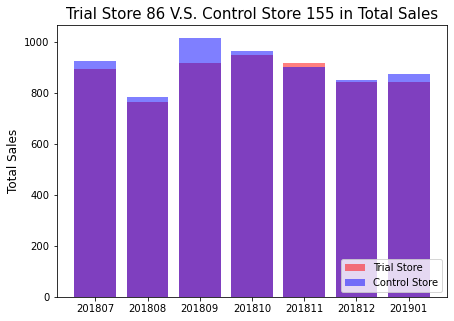

In [336]:
# Visualise the comparison of TOTAL SALES for 86 & 155

fig,ax=plt.subplots(figsize=(7,5))

x=np.arange(len(preTrialMeasures[preTrialMeasures['STORE_NBR']==86]['YEARMONTH']))

rect_trial=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==86]['TOT_SALES'],color='red',alpha=0.5,label='Trial Store')
rect_ctrl=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==155]['TOT_SALES'],color='blue',alpha=0.5,label='Control Store')

ax.set_ylabel('Total Sales',fontsize=12)
ax.set_title('Trial Store 86 V.S. Control Store 155 in Total Sales',fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(preTrialMeasures[preTrialMeasures['STORE_NBR']==86]['YEARMONTH'])
ax.legend(loc='lower right')

plt.show()

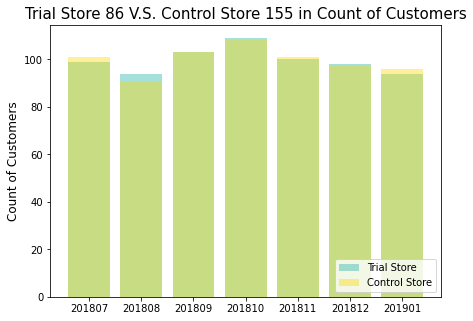

In [337]:
# Visualise the comparison of NO OF CUSTOMERS for 86 & 155

fig,ax=plt.subplots(figsize=(7,5))

x=np.arange(len(preTrialMeasures[preTrialMeasures['STORE_NBR']==86]['YEARMONTH']))

rect_trial=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==86]['N_CUSTOMERS'],color='lightseagreen',alpha=0.4,label='Trial Store')
rect_ctrl=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==155]['N_CUSTOMERS'],color='gold',alpha=0.4,label='Control Store')

ax.set_ylabel('Count of Customers',fontsize=12)
ax.set_title('Trial Store 86 V.S. Control Store 155 in Count of Customers',fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(preTrialMeasures[preTrialMeasures['STORE_NBR']==86]['YEARMONTH'])
ax.legend(loc='lower right')

plt.show()

#### For trial store 88

In [338]:
for measure in ['TOT_SALES','N_CUSTOMERS']:
    Corr_Table=CalcCorrTable(measure,88)
    Dis_Table=CalcDistTable([measure],88)
    Compo_Table=pd.merge(Corr_Table,Dis_Table,on=['YEARMONTH','TRIAL_STORE','CTRL_STORE'])
    Compo_Table['COMPO_SCORE']=Compo_Table['MAGNITUDE_SCORE']*0.5 + abs(Compo_Table['CORR_SCORE'])*0.5
    print(measure,'top 3 stores with scores are \n',Compo_Table.groupby(['CTRL_STORE']).agg({'COMPO_SCORE':'mean'}).sort_values(by='COMPO_SCORE',ascending=False).iloc[:3])

TOT_SALES top 3 stores with scores are 
             COMPO_SCORE
CTRL_STORE             
237            0.979298
203            0.976580
40             0.970582
N_CUSTOMERS top 3 stores with scores are 
             COMPO_SCORE
CTRL_STORE             
237            0.993909
203            0.972315
40             0.971207


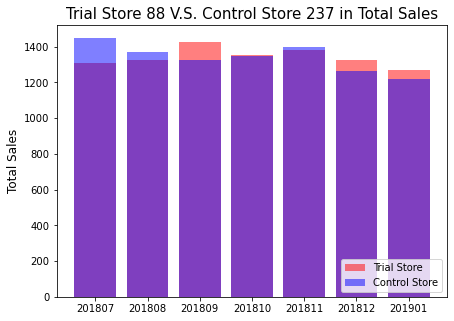

In [339]:
# Visualise the comparison of TOTAL SALES for 88 & 237

fig,ax=plt.subplots(figsize=(7,5))

x=np.arange(len(preTrialMeasures[preTrialMeasures['STORE_NBR']==88]['YEARMONTH']))

rect_trial=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==88]['TOT_SALES'],color='red',alpha=0.5,label='Trial Store')
rect_ctrl=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==237]['TOT_SALES'],color='blue',alpha=0.5,label='Control Store')

ax.set_ylabel('Total Sales',fontsize=12)
ax.set_title('Trial Store 88 V.S. Control Store 237 in Total Sales',fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(preTrialMeasures[preTrialMeasures['STORE_NBR']==88]['YEARMONTH'])
ax.legend(loc='lower right')

plt.show()

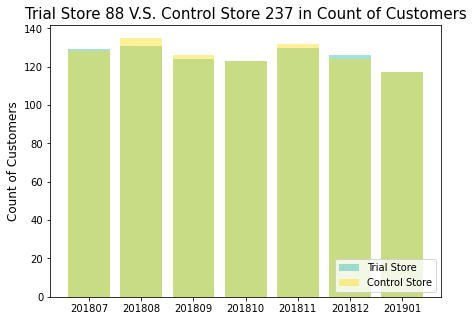

In [340]:
# Visualise the comparison of NO OF CUSTOMERS for 88 & 237

fig,ax=plt.subplots(figsize=(7,5))

x=np.arange(len(preTrialMeasures[preTrialMeasures['STORE_NBR']==88]['YEARMONTH']))

rect_trial=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==88]['N_CUSTOMERS'],color='lightseagreen',alpha=0.4,label='Trial Store')
rect_ctrl=ax.bar(x,height=preTrialMeasures[preTrialMeasures['STORE_NBR']==237]['N_CUSTOMERS'],color='gold',alpha=0.4,label='Control Store')

ax.set_ylabel('Count of Customers',fontsize=12)
ax.set_title('Trial Store 88 V.S. Control Store 237 in Count of Customers',fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(preTrialMeasures[preTrialMeasures['STORE_NBR']==88]['YEARMONTH'])
ax.legend(loc='lower right')

plt.show()

#### Summary:
According to the following 3 different methods:
- correlations
- magnitude distance
- visuals

we have the following control stores for the corresponding trial store:
- trial store 77:control store 233
- trial store 86:control store 155
- trial store 88:control store 237

# 3.0 Assess performance of trial stores
- For trial store 77
- For trial store 66
- For trial store 88
- Summary

#### For trial store 77
As we will will use the same methods to assess the impact for 3 trial stores and for 2 metrics

so we will firstly define the function to simplify the process

In [463]:
# get t values & corresponding measures

def tvalue(trial_store,ctrl_store,metrics):
    
    # get the scaling factor:
    Factor=preTrialMeasures[preTrialMeasures['STORE_NBR']==trial_store][metrics].sum()/preTrialMeasures[preTrialMeasures['STORE_NBR']==ctrl_store][metrics].sum()
    
    # apply scaling factor
    scaledControlMetrics=measureOverTime[measureOverTime['STORE_NBR']==ctrl_store]
    scaledControlMetrics['SCALED_'+metrics]=Factor*scaledControlMetrics[metrics]
    
    # calculate percentage difference for trial period
    trialMetrics=trialMeasure[trialMeasure['STORE_NBR']==trial_store].set_index('YEARMONTH')[metrics]
    scaledControlMetrics_trial=scaledControlMetrics[(scaledControlMetrics['YEARMONTH']>=201902) & (scaledControlMetrics['YEARMONTH']<=201904)].set_index('YEARMONTH')['SCALED_'+metrics]
    percentageDiff=abs(trialMetrics-scaledControlMetrics_trial)/((trialMetrics+scaledControlMetrics_trial)/2)
    
    # calculate percentage difference for pre trial period
    scaledControlMetrics_pre=scaledControlMetrics[(scaledControlMetrics['YEARMONTH']<201902)].set_index('YEARMONTH')['SCALED_'+metrics]
    trialMetrics_pre=preTrialMeasures[preTrialMeasures['STORE_NBR']==trial_store].set_index('YEARMONTH')[metrics]
    percentageDiff_pre=abs(trialMetrics_pre-scaledControlMetrics_pre)/((trialMetrics_pre+scaledControlMetrics_pre)/2)
    
    # get the test statistics
    std=percentageDiff_pre.std()
    mean=percentageDiff_pre.mean()
    for i in range(len(percentageDiff)):
        print(percentageDiff.index[i],':',(percentageDiff.values[i]-mean)/std)
    
    return scaledControlMetrics_trial,trialMetrics,std
    

In [464]:
# test the function

scaledControlMetrics_trial,trialMetrics,std=tvalue(77,233,'TOT_SALES')
print(t.ppf(0.95,df=6),
      '\n',
      scaledControlMetrics_trial,
      '\n',
     trialMetrics,'\n',std)

201902 : -0.3915339111404506
201903 : 4.6945579809863185
201904 : 8.073445723005706
1.9431802803927816 
 YEARMONTH
201902    249.762622
201903    203.802205
201904    162.345704
Name: SCALED_TOT_SALES, dtype: float64 
 YEARMONTH
201902    235.0
201903    278.5
201904    263.5
Name: TOT_SALES, dtype: float64 
 0.04892726069143253


<ipython-input-463-2269f66aa4ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlMetrics['SCALED_'+metrics]=Factor*scaledControlMetrics[metrics]


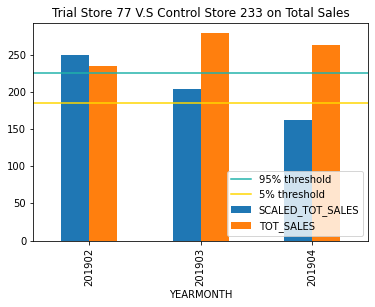

In [465]:
# assess performance by total sales:
    
ctrl_store=scaledControlMetrics_trial.to_frame()
trial_store=trialMetrics.to_frame()
visual=pd.concat([ctrl_store,trial_store],axis=1)
visual.plot.bar()

#calculate 95% confidence interval
threshold_5=scaledControlMetrics_trial.mean()*(1-std*2)
threshold_95=scaledControlMetrics_trial.mean()*(1+std*2)

plt.axhline(y=threshold_95,color='lightseagreen',label='95% threshold')
plt.axhline(y=threshold_5,color='gold',label='5% threshold')
plt.legend(loc='lower right')
plt.title('Trial Store 77 V.S Control Store 233 on Total Sales')
    
plt.show()

In [470]:
# assess the impact in terms of no of customers
scaledControlMetrics_trial,trialMetrics,std=tvalue(77,233,'N_CUSTOMERS')
print(t.ppf(0.95,df=6),
      '\n',
      scaledControlMetrics_trial,
      '\n',
     trialMetrics,'\n',std)

201902 : -0.8768108879953223
201903 : 11.216197307486091
201904 : 23.5277022803017
1.9431802803927816 
 YEARMONTH
201902    45.151007
201903    40.134228
201904    30.100671
Name: SCALED_N_CUSTOMERS, dtype: float64 
 YEARMONTH
201902    45
201903    50
201904    47
Name: N_CUSTOMERS, dtype: int64 
 0.01782540740663612


<ipython-input-463-2269f66aa4ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlMetrics['SCALED_'+metrics]=Factor*scaledControlMetrics[metrics]


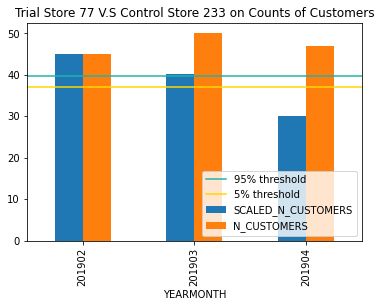

In [471]:
# assess by visualising it

ctrl_store=scaledControlMetrics_trial.to_frame()
trial_store=trialMetrics.to_frame()
visual=pd.concat([ctrl_store,trial_store],axis=1)
visual.plot.bar()

#calculate 95% confidence interval
threshold_5=scaledControlMetrics_trial.mean()*(1-std*2)
threshold_95=scaledControlMetrics_trial.mean()*(1+std*2)

plt.axhline(y=threshold_95,color='lightseagreen',label='95% threshold')
plt.axhline(y=threshold_5,color='gold',label='5% threshold')
plt.legend(loc='lower right')
plt.title('Trial Store 77 V.S Control Store 233 on Counts of Customers')
    
plt.show()

#### For trial store 86

In [472]:
# Assess total sales
scaledControlMetrics_trial,trialMetrics,std=tvalue(86,155,'TOT_SALES')
print(t.ppf(0.95,df=6),
      '\n',
      scaledControlMetrics_trial,
      '\n',
     trialMetrics,'\n',std)

201902 : 1.1066523159611152
201903 : 9.372495931729732
201904 : 0.34375269335748015
1.9431802803927816 
 YEARMONTH
201902    864.522060
201903    780.320405
201904    819.317024
Name: SCALED_TOT_SALES, dtype: float64 
 YEARMONTH
201902     913.2
201903    1026.8
201904     848.2
Name: TOT_SALES, dtype: float64 
 0.02637634362673643


<ipython-input-463-2269f66aa4ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlMetrics['SCALED_'+metrics]=Factor*scaledControlMetrics[metrics]


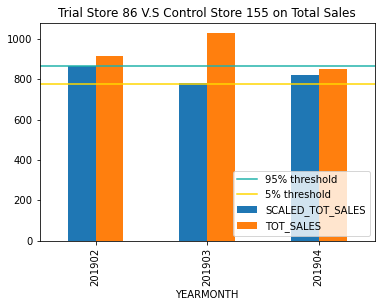

In [473]:
# Visualising the total sales

ctrl_store=scaledControlMetrics_trial.to_frame()
trial_store=trialMetrics.to_frame()
visual=pd.concat([ctrl_store,trial_store],axis=1)
visual.plot.bar()

#calculate 95% confidence interval
threshold_5=scaledControlMetrics_trial.mean()*(1-std*2)
threshold_95=scaledControlMetrics_trial.mean()*(1+std*2)

plt.axhline(y=threshold_95,color='lightseagreen',label='95% threshold')
plt.axhline(y=threshold_5,color='gold',label='5% threshold')
plt.legend(loc='lower right')
plt.title('Trial Store 86 V.S Control Store 155 on Total Sales')
    
plt.show()

In [474]:
# assess no of customers
scaledControlMetrics_trial,trialMetrics,std=tvalue(86,155,'N_CUSTOMERS')
print(t.ppf(0.95,df=6),
      '\n',
      scaledControlMetrics_trial,
      '\n',
     trialMetrics,'\n',std)

201902 : 9.842308112121641
201903 : 17.608051753234434
201904 : 4.171191911489473
1.9431802803927816 
 YEARMONTH
201902    95.0
201903    94.0
201904    99.0
Name: SCALED_N_CUSTOMERS, dtype: float64 
 YEARMONTH
201902    107
201903    115
201904    105
Name: N_CUSTOMERS, dtype: int64 
 0.010577873853063899


<ipython-input-463-2269f66aa4ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlMetrics['SCALED_'+metrics]=Factor*scaledControlMetrics[metrics]


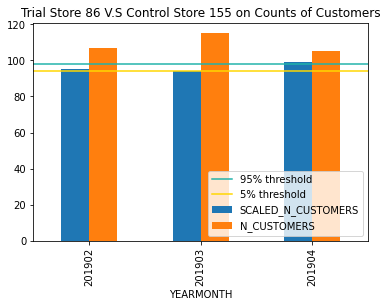

In [475]:
# assess by visualising it

ctrl_store=scaledControlMetrics_trial.to_frame()
trial_store=trialMetrics.to_frame()
visual=pd.concat([ctrl_store,trial_store],axis=1)
visual.plot.bar()

#calculate 95% confidence interval
threshold_5=scaledControlMetrics_trial.mean()*(1-std*2)
threshold_95=scaledControlMetrics_trial.mean()*(1+std*2)

plt.axhline(y=threshold_95,color='lightseagreen',label='95% threshold')
plt.axhline(y=threshold_5,color='gold',label='5% threshold')
plt.legend(loc='lower right')
plt.title('Trial Store 86 V.S Control Store 155 on Counts of Customers')
    
plt.show()

#### For trial store 88

In [476]:
# Assess total sales
scaledControlMetrics_trial,trialMetrics,std=tvalue(88,237,'TOT_SALES')
print(t.ppf(0.95,df=6),
      '\n',
      scaledControlMetrics_trial,
      '\n',
     trialMetrics,'\n',std)

201902 : -0.48655192952944276
201903 : 4.520791538191403
201904 : 3.860063575155905
1.9431802803927816 
 YEARMONTH
201902    1406.989143
201903    1210.082775
201904    1206.477165
Name: SCALED_TOT_SALES, dtype: float64 
 YEARMONTH
201902    1370.2
201903    1477.2
201904    1439.4
Name: TOT_SALES, dtype: float64 
 0.03441089754539567


<ipython-input-463-2269f66aa4ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlMetrics['SCALED_'+metrics]=Factor*scaledControlMetrics[metrics]


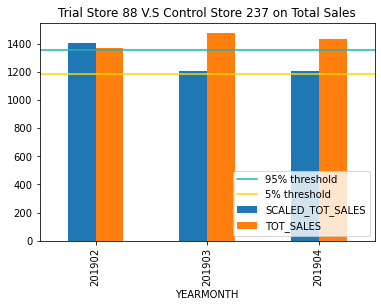

In [477]:
# assess by visualising it

ctrl_store=scaledControlMetrics_trial.to_frame()
trial_store=trialMetrics.to_frame()
visual=pd.concat([ctrl_store,trial_store],axis=1)
visual.plot.bar()

#calculate 95% confidence interval
threshold_5=scaledControlMetrics_trial.mean()*(1-std*2)
threshold_95=scaledControlMetrics_trial.mean()*(1+std*2)

plt.axhline(y=threshold_95,color='lightseagreen',label='95% threshold')
plt.axhline(y=threshold_5,color='gold',label='5% threshold')
plt.legend(loc='lower right')
plt.title('Trial Store 88 V.S Control Store 237 on Total Sales')
    
plt.show()

In [478]:
# assess no of customers
scaledControlMetrics_trial,trialMetrics,std=tvalue(88,237,'N_CUSTOMERS')
print(t.ppf(0.95,df=6),
      '\n',
      scaledControlMetrics_trial,
      '\n',
     trialMetrics,'\n',std)

201902 : -0.354468114266605
201903 : 14.962317320071637
201904 : 7.693572845363284
1.9431802803927816 
 YEARMONTH
201902    125.288136
201903    118.327684
201904    119.322034
Name: SCALED_N_CUSTOMERS, dtype: float64 
 YEARMONTH
201902    124
201903    134
201904    128
Name: N_CUSTOMERS, dtype: int64 
 0.007435464986617887


<ipython-input-463-2269f66aa4ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlMetrics['SCALED_'+metrics]=Factor*scaledControlMetrics[metrics]


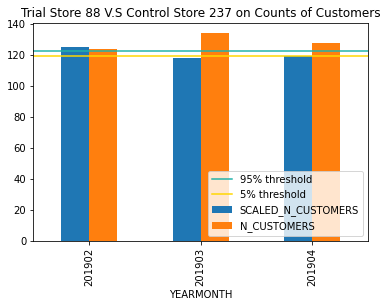

In [479]:
# assess by visualising it

ctrl_store=scaledControlMetrics_trial.to_frame()
trial_store=trialMetrics.to_frame()
visual=pd.concat([ctrl_store,trial_store],axis=1)
visual.plot.bar()

#calculate 95% confidence interval
threshold_5=scaledControlMetrics_trial.mean()*(1-std*2)
threshold_95=scaledControlMetrics_trial.mean()*(1+std*2)

plt.axhline(y=threshold_95,color='lightseagreen',label='95% threshold')
plt.axhline(y=threshold_5,color='gold',label='5% threshold')
plt.legend(loc='lower right')
plt.title('Trial Store 88 V.S Control Store 237 on Counts of Customers')
    
plt.show()

### Summary

- Only trial store 77 have increases in sales and customers of statistically significance for the whole trial period.
- For trial store 86. while there is significantly increase in customers for the whole trial periods, just sales in March are recognised significantly increased. 
- For trial store 88, there are significantly increases in sales and customers for 2 of 3 trial months: March and April